In [ ]:
!nvidia-smi

Mon Aug 15 12:31:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)
drive.mount('/content/gdrive')
!ls
%cd gdrive/My\ Drive/phd-thesis/
!ls

Mounted at /content/gdrive
gdrive	sample_data
/content/gdrive/My Drive/phd-thesis
 adasyn_TL_MajorVoting_balance.ipynb
 ADASYN_TL_MajorVoting_imb.ipynb
 adasyn_xgboost_20_imb.ipynb
 adasyn_xgboost_20.ipynb
 adasyn_xgboost_fulldata_balance.ipynb
 adasyn_xgboost_fulldata_imb.ipynb
 Attack_Types.csv
'bagging&ensemble.py'
 cnn.ipynb
 CNN-test-data
 CNN-test-data-balanced
 CNN-test-data-balanced-dropout
 CNN-test-data-imb
 createCNN_Balanced_fulldata.ipynb
 createCNN_Balanced.ipynb
 createNetwork-211025.py
 createNetwork-CNN-imb.ipynb
'createNetwork-testdata (1).ipynb'
 createNetwork-testdata.ipynb
 createNetwork-testdata.py
 ensemble_balance-old.ipynb
 ensemble_imb-old.ipynb
 Evaluate_adasyn_xgboost_fulldata_balance.ipynb
 Evaluate_adasyn_xgboost_fulldata_imb.ipynb
 Evaluate_adasyn_xgboost_model_20.ipynb
 evaluate_auc_3Algorithm_macro.ipynb
 evaluate_auc_3Algorithm_micro.ipynb
 Evaluate_CNN_Balacanced.ipynb
 Evaluate_CNN_imb.ipynb
 Evaluate_PR_3Algorithms.ipynb
 Evaluate_PR_CNN.ipynb
 Eval

test_x         0         1         2    3         4         5         6         7    \
0 -0.110249 -0.007762 -0.004919    0 -0.089486 -0.007736 -0.095076 -0.027023   
1 -0.110249 -0.007762 -0.004919    0 -0.089486 -0.007736 -0.095076 -0.027023   
2 -0.109481 -0.005551 -0.004919    0 -0.089486 -0.007736 -0.095076 -0.027023   
3 -0.110249 -0.007759 -0.004919    0 -0.089486 -0.007736 -0.095076 -0.027023   
4 -0.109865 -0.007762 -0.004915    0 -0.089486 -0.007736 -0.095076 -0.027023   

   8         9    ...  105  106  107  108  109  110  111  112  113  114  
0    0 -0.011664  ...    0    0    0    1    0    0    0    0    0    0  
1    0 -0.011664  ...    0    0    0    1    0    0    0    0    0    0  
2    0 -0.011664  ...    0    0    0    0    0    0    0    0    0    0  
3    0 -0.011664  ...    0    0    0    0    0    0    0    0    0    0  
4    0 -0.011664  ...    0    0    0    0    1    0    0    0    0    0  

[5 rows x 115 columns]
test_y    0
0  1
1  1
2  0
3  2
4  2
origina

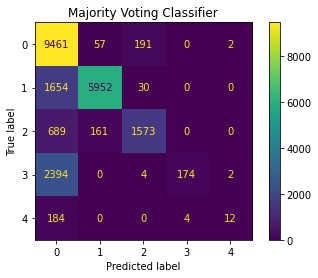

y: [[0 1 0 0 0]
 [0 1 0 0 0]
 [1 0 0 0 0]
 ...
 [0 1 0 0 0]
 [1 0 0 0 0]
 [0 0 1 0 0]]
n_classes: 5


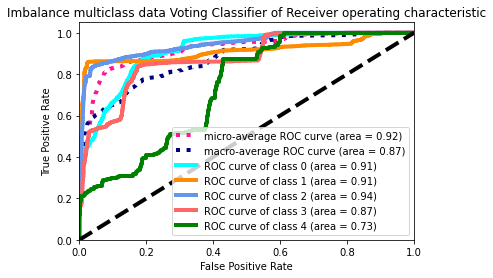

One-vs-One ROC AUC scores:
0.824282 (macro),
0.875109 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.874543 (macro),
0.909104 (weighted by prevalence),
0.920776(micro)


In [2]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jun 29 16:09:40 2022
Evaluate ensemble voting classifier
@author: Administrator
"""


# -*- coding: utf-8 -*-
"""
Created on Wed Jun  8 11:13:03 2022

load adasyn and xgbboost balanced model, test on 20% test dataset and evaluate
try using ROC curve
@author: Administrator
"""
# import joblib
import pandas as pd
import xgboost as xgb

from sklearn.ensemble import VotingClassifier as vc 
from sklearn.metrics import confusion_matrix, zero_one_loss, accuracy_score, \
    classification_report, roc_auc_score, roc_curve, auc, plot_confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.preprocessing import label_binarize
import numpy as np
from sklearn.multiclass import OneVsRestClassifier
from imblearn.metrics import geometric_mean_score, classification_report_imbalanced
import joblib
# train_x = pd.read_csv('KDDTrain_x_20.csv',header=None)
# train_Y = pd.read_csv('KDDTrain_y_20.csv',header=None)
# train_Y[0]=list(train_Y[0].map({'benign':0, 'dos':1, 'probe':2, 'r2l':3, 'u2r':4}))

# print("train_x", train_x.head())
# print("train_y", train_Y.head())


#testing dataset 20%
test_x = pd.read_csv('KDDTest_x.csv',header=None)
test_Y = pd.read_csv('KDDTest_y.csv',header=None)
test_x.drop(test_x.columns[[115,116,117]], axis=1, inplace=True)

test_Y[0]=list(test_Y[0].map({'benign':0, 'dos':1, 'probe':2, 'r2l':3, 'u2r':4}))
print("test_x", test_x.head())
print("test_y", test_Y.head())

test_Y  = test_Y.values.ravel()
print('original dataset shape %s' % Counter(test_Y))
#########

"""
#*******try using tomek link on test dataset to make balance
#only smote
from imblearn.over_sampling import SMOTE
sm = SMOTE (sampling_strategy='auto', random_state=0)
# train_x_sm, train_Y_sm = sm.fit_resample(train_x, train_Y)
test_x_sm, test_Y_sm = sm.fit_resample(test_x, test_Y)
print('smote dataset shape %s' % Counter(test_Y_sm))


#Tomek Links
from imblearn.under_sampling import TomekLinks
sampling_strategy = "all"
tl = TomekLinks(sampling_strategy=sampling_strategy)
# x_res, Y_res = tl.fit_resample(train_x_sm, train_Y_sm)
x_res, Y_res = tl.fit_resample(test_x_sm, test_Y_sm)
print('Tomek Links dataset shape %s' % Counter(Y_res))
#*************************
"""

#***ENN
# from imblearn.under_sampling import EditedNearestNeighbours
# sampling_strategy = "all"
# en = EditedNearestNeighbours(sampling_strategy=sampling_strategy)
# # x_res, Y_res = tl.fit_resample(train_x_sm, train_Y_sm)
# x_res, Y_res = en.fit_resample(test_x_sm, test_Y_sm)
# print('ENN dataset shape %s' % Counter(Y_res))


"""
#******* whole testing dataset
w_test_x = pd.read_csv('KDDTest_x.csv',header=None)
w_test_Y = pd.read_csv('KDDTest_y.csv',header=None)

# w_test_x.drop(pd.colums[[115, 116, 117]], axis=1)
w_test_x.drop(w_test_x.columns[[115, 116, 117]], axis=1, inplace=True)

w_test_Y[0]=list(w_test_Y[0].map({'benign':0, 'dos':1, 'probe':2, 'r2l':3, 'u2r':4}))
print("w_test_x", w_test_x.head())
print("w_test_y", w_test_Y.head())

w_test_Y  = w_test_Y.values.ravel()
##########
"""

# load model
#clf = xgb.XGBClassifier()
#clf = vc.VotingClassifier()
#my_model = joblib.load("myXgbModel.pkl")
#clf.load_model("myXgb_adasyn.json")

#clf = vc.votingClassifier()
clf = joblib.load("VotingClassifier-imb.pkl")

#metrics
#subset test data
# pred_y = clf.predict(test_x)
# results = confusion_matrix(test_Y, pred_y)
# error = zero_one_loss(test_Y, pred_y)
# target_names = ['benign 0', 'dos 1', 'probe 2', 'r2l 3', 'u2r 4']
# print("20% result: \n" , results)
# print("20% error:", error)
# print("20% validation:", accuracy_score(test_Y, pred_y))
# print(classification_report(test_Y, pred_y, target_names=target_names))

# after tomek link 
pred_y = clf.predict(test_x)  #x_res
results = confusion_matrix(test_Y, pred_y)   #Y_res

error = zero_one_loss(test_Y, pred_y)   #Y_res
target_names = ['benign 0', 'dos 1', 'probe 2', 'r2l 3', 'u2r 4']
print("20% result: \n" , results)
print("20% error:", error)
print("20% validation:", accuracy_score(test_Y, pred_y))   #Y_res
yy = clf.predict_proba(test_x)  #x_res
# [:, 1]

# yy = clf.decision_function(x_res)[:, 1]
rac = roc_auc_score(test_Y, yy, multi_class='ovr', average ='macro')  #Y_res
print("ROC AUC Score:", rac)
print(classification_report(test_Y, pred_y, target_names=target_names))   #Y_res


print(classification_report_imbalanced(test_Y, pred_y, digits=4, target_names=target_names))  #Y_res
print(f"The geometric mean is {geometric_mean_score(test_Y, pred_y):.3f}") #Y_res
#import seaborn as sns

#sns.set_context("poster")

# disp = plot_confusion_matrix(clf, test_x, test_Y, colorbar=False)  #x_res, Y_res


cm = confusion_matrix(test_Y, pred_y, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
_ = disp.ax_.set_title("Majority Voting Classifier")
plt.show()
# ***plot confusion matrix
# plt.matshow(results, cmap=plt.cm.gray)
# plt.show()

"""
#whole test data
w_pred_y = clf.predict(w_test_x)
w_results = confusion_matrix(w_test_Y, w_pred_y)
w_error = zero_one_loss(w_test_Y, w_pred_y)
print("w_result: \n" , w_results)
print("w_error:", w_error)
print("w_validation:", accuracy_score(w_test_Y, w_pred_y))
print(classification_report(w_test_Y, w_pred_y, target_names=target_names))
"""

# plot roc curve
y = label_binarize(test_Y, classes=[0, 1, 2, 3, 4])  #Y_res
n_classes = y.shape[1]

print("y:", y)
print("n_classes:", n_classes)

lw = 4

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    # fpr[i], tpr[i], _ = roc_curve(Y_res[:, i], y[:, i])
    # fpr[i], tpr[i], threshold = roc_curve(y[:, i], yy[:, i], pos_label=0)
    fpr[i], tpr[i], threshold = roc_curve(y[:, i], yy[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), yy.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)


plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)



colors = cycle(["aqua", "darkorange", "cornflowerblue", "#FF6666", "green"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Imbalance multiclass data Voting Classifier of Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()


# compute roc_auc_score
# y_prob = classifier.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(test_Y, yy, multi_class="ovo", average="macro")  #Y_res
weighted_roc_auc_ovo = roc_auc_score(
    test_Y, yy, multi_class="ovo", average="weighted"
)
macro_roc_auc_ovr = roc_auc_score(test_Y, yy, multi_class="ovr", average="macro")
weighted_roc_auc_ovr = roc_auc_score(
    test_Y, yy, multi_class="ovr", average="weighted"
) #Y_res
print(
    "One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo)
)
print(
    "One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence),\n{:.6f}"   #leon
    "(micro)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr, roc_auc["micro"])  #leon
)

